# Casson model for simulating Non Newtonian blood flow

In [1]:
import math
from lbmpy.session import *

from lbmpy.non_newtonian_models import CassonsParameters
from lbmpy.relaxationrates import lattice_viscosity_from_relaxation_rate

The primary source for the implementation of the Casson model can be found [here](https://doi.org/10.1007/s10955-005-8415-x)

In [2]:
stencil = LBStencil(Stencil.D3Q27)

W = 41
L = 1 * W
domain_size = (L, W, W)

omega = 1.0
nu = lattice_viscosity_from_relaxation_rate(omega)

driving_force = 0.0001

The only parameter of the model is the so-called yield_stress. The main idea is that no strain rate is observed below some stress. However, this leads to the problem that the modified relaxation rate might no longer lead to stable LBM simulations. Thus an upper and lower limit for the shear relaxation rate must be given. All the parameters are combined in the `CassonsParameters` dataclass

In [3]:
# yield stress
sigma_y = 2*1e-6

parameters = CassonsParameters(yield_stress=sigma_y, omega_min=0.2, omega_max=1.98)

In [4]:
dh = ps.create_data_handling(domain_size=domain_size, periodicity=(True, False, False))

src = dh.add_array('src', values_per_cell=len(stencil))
dh.fill('src', 0.0, ghost_layers=True)
dst = dh.add_array('dst', values_per_cell=len(stencil))
dh.fill('dst', 0.0, ghost_layers=True)

velField = dh.add_array('velField', values_per_cell=dh.dim)
dh.fill('velField', 0.0, ghost_layers=True)

To activate the Casson model in the derivation of the LBM equations, simply pass the parameter class to the LBMConfig

In [5]:
lbm_config = LBMConfig(stencil=Stencil.D3Q27, method=Method.SRT,
                       relaxation_rate=1, compressible=False, force=(driving_force / L, 0,0),
                       cassons=parameters,
                       output={'velocity': velField}, kernel_type='stream_pull_collide')

method = create_lb_method(lbm_config=lbm_config)

In [6]:
init = pdf_initialization_assignments(method, 1.0, velocity=velField.center_vector, pdfs=src.center_vector)

ast_init = ps.create_kernel(init, target=dh.default_target)
kernel_init = ast_init.compile()

dh.run_kernel(kernel_init)

The main expression for the Casson model is:
$$
\lvert \dot{\gamma} \rvert = 2 \sqrt{S_{\alpha \beta} S_{\alpha \beta}} = \frac{3 \sigma}{\tau_\mu \nu^2 \rho \Delta t}
$$

where $\lvert \dot{\gamma} \rvert$ is the shear strain rate, $\sigma$ is the shear stress, $\nu$ is a constant viscosity $\rho$ is the density and $\Delta t$ is the lattice timestep size. The strain rate tensor is computed in the same way as in `Tutorial 06: Modifying a LBM method: Smagorinsky model`. 

In order to calculate the adapted viscosity the following equation is used:

$$
\sqrt{\frac{\mu}{\eta}} = \frac{1}{1 - \theta} \left[1 + \sqrt{\theta \left[ 1 + \frac{\rho \Delta t \nu^2}{\eta} \frac{3}{2} \left( 1 - \theta \right) \right]} \right]
$$

where $\theta = \frac{\sigma_y}{\sigma}$

In [7]:
lbm_optimisation = LBMOptimisation(symbolic_field=src, symbolic_temporary_field=dst)
update = create_lb_update_rule(lbm_config=lbm_config,
                               lbm_optimisation=lbm_optimisation)

ast_kernel = ps.create_kernel(update, target=dh.default_target, cpu_openmp=False)
kernel = ast_kernel.compile()

In [8]:
update

"$$vel0Term \leftarrow {src}_{(-1,1,-1)}^{21} + {src}_{(-1,-1,-1)}^{19} + {src}_{(-1,0,-1)}^{14} + {src}_{(-1,1,0)}^{10} + {src}_{(-1,-1,0)}^{8} + {src}_{(-1,1,1)}^{25} + {src}_{(-1,-1,1)}^{23} + {src}_{(-1,0,1)}^{18} + {src}_{(-1,0,0)}^{4}$$"
"$$vel1Term \leftarrow {src}_{(1,-1,-1)}^{20} + {src}_{(0,-1,-1)}^{11} + {src}_{(1,-1,0)}^{7} + {src}_{(0,-1,0)}^{1} + {src}_{(1,-1,1)}^{24} + {src}_{(0,-1,1)}^{15}$$"
"$$vel2Term \leftarrow {src}_{(1,0,-1)}^{13} + {src}_{(1,1,-1)}^{22} + {src}_{(0,1,-1)}^{12} + {src}_{(0,0,-1)}^{5}$$"
"$$\delta_{\rho} \leftarrow {src}_{(0,0,0)}^{0} + {src}_{(1,0,0)}^{3} + {src}_{(1,1,0)}^{9} + {src}_{(0,1,0)}^{2} + {src}_{(1,0,1)}^{17} + {src}_{(1,1,1)}^{26} + {src}_{(0,1,1)}^{16} + {src}_{(0,0,1)}^{6} + vel0Term + vel1Term + vel2Term$$"
"$$u_{0} \leftarrow - {src}_{(1,0,-1)}^{13} - {src}_{(1,1,-1)}^{22} - {src}_{(1,-1,-1)}^{20} - {src}_{(1,0,0)}^{3} - {src}_{(1,1,0)}^{9} - {src}_{(1,-1,0)}^{7} - {src}_{(1,0,1)}^{17} - {src}_{(1,1,1)}^{26} - {src}_{(1,-1,1)}^{24} + vel0Term + 1.21951219512195 \cdot 10^{-6}$$"
"$$u_{1} \leftarrow - {src}_{(1,1,-1)}^{22} - {src}_{(-1,1,-1)}^{21} - {src}_{(0,1,-1)}^{12} + {src}_{(-1,-1,-1)}^{19} - {src}_{(1,1,0)}^{9} - {src}_{(-1,1,0)}^{10} - {src}_{(0,1,0)}^{2} + {src}_{(-1,-1,0)}^{8} - {src}_{(1,1,1)}^{26} - {src}_{(-1,1,1)}^{25} - {src}_{(0,1,1)}^{16} + {src}_{(-1,-1,1)}^{23} + vel1Term$$"
"$$u_{2} \leftarrow {src}_{(-1,1,-1)}^{21} + {src}_{(1,-1,-1)}^{20} + {src}_{(-1,-1,-1)}^{19} + {src}_{(0,-1,-1)}^{11} + {src}_{(-1,0,-1)}^{14} - {src}_{(1,0,1)}^{17} - {src}_{(1,1,1)}^{26} - {src}_{(-1,1,1)}^{25} - {src}_{(0,1,1)}^{16} - {src}_{(1,-1,1)}^{24} - {src}_{(-1,-1,1)}^{23} - {src}_{(0,-1,1)}^{15} - {src}_{(-1,0,1)}^{18} - {src}_{(0,0,1)}^{6} + vel2Term$$"
"$$\sigma \leftarrow \sqrt{2 \left(- {src}_{(1,0,-1)}^{13} - {src}_{(1,1,-1)}^{22} + {src}_{(-1,1,-1)}^{21} - {src}_{(1,-1,-1)}^{20} + {src}_{(-1,-1,-1)}^{19} + {src}_{(-1,0,-1)}^{14} + {src}_{(1,0,1)}^{17} + {src}_{(1,1,1)}^{26} - {src}_{(-1,1,1)}^{25} + {src}_{(1,-1,1)}^{24} - {src}_{(-1,-1,1)}^{23} - {src}_{(-1,0,1)}^{18} - u_{0} u_{2}\right)^{2} + 2 \left(- {src}_{(1,1,-1)}^{22} - {src}_{(-1,1,-1)}^{21} - {src}_{(0,1,-1)}^{12} + {src}_{(1,-1,-1)}^{20} + {src}_{(-1,-1,-1)}^{19} + {src}_{(0,-1,-1)}^{11} + {src}_{(1,1,1)}^{26} + {src}_{(-1,1,1)}^{25} + {src}_{(0,1,1)}^{16} - {src}_{(1,-1,1)}^{24} - {src}_{(-1,-1,1)}^{23} - {src}_{(0,-1,1)}^{15} - u_{1} u_{2}\right)^{2} + 2 \left({src}_{(1,1,-1)}^{22} - {src}_{(-1,1,-1)}^{21} - {src}_{(1,-1,-1)}^{20} + {src}_{(-1,-1,-1)}^{19} + {src}_{(1,1,0)}^{9} - {src}_{(-1,1,0)}^{10} - {src}_{(1,-1,0)}^{7} + {src}_{(-1,-1,0)}^{8} + {src}_{(1,1,1)}^{26} - {src}_{(-1,1,1)}^{25} - {src}_{(1,-1,1)}^{24} + {src}_{(-1,-1,1)}^{23} - u_{0} u_{1}\right)^{2} + \left({src}_{(1,0,-1)}^{13} + {src}_{(1,1,-1)}^{22} + {src}_{(-1,1,-1)}^{21} + {src}_{(0,1,-1)}^{12} + {src}_{(1,-1,-1)}^{20} + {src}_{(-1,-1,-1)}^{19} + {src}_{(0,-1,-1)}^{11} + {src}_{(-1,0,-1)}^{14} + {src}_{(0,0,-1)}^{5} + {src}_{(1,0,1)}^{17} + {src}_{(1,1,1)}^{26} + {src}_{(-1,1,1)}^{25} + {src}_{(0,1,1)}^{16} + {src}_{(1,-1,1)}^{24} + {src}_{(-1,-1,1)}^{23} + {src}_{(0,-1,1)}^{15} + {src}_{(-1,0,1)}^{18} + {src}_{(0,0,1)}^{6} - \frac{\delta_{\rho}}{3} - u_{2}^{2}\right)^{2} + \left({src}_{(1,0,-1)}^{13} + {src}_{(1,1,-1)}^{22} + {src}_{(-1,1,-1)}^{21} + {src}_{(1,-1,-1)}^{20} + {src}_{(-1,-1,-1)}^{19} + {src}_{(-1,0,-1)}^{14} + {src}_{(1,0,0)}^{3} + {src}_{(1,1,0)}^{9} + {src}_{(-1,1,0)}^{10} + {src}_{(1,-1,0)}^{7} + {src}_{(-1,-1,0)}^{8} + {src}_{(1,0,1)}^{17} + {src}_{(1,1,1)}^{26} + {src}_{(-1,1,1)}^{25} + {src}_{(1,-1,1)}^{24} + {src}_{(-1,-1,1)}^{23} + {src}_{(-1,0,1)}^{18} + {src}_{(-1,0,0)}^{4} - \frac{\delta_{\rho}}{3} - u_{0}^{2}\right)^{2} + \left({src}_{(1,1,-1)}^{22} + {src}_{(-1,1,-1)}^{21} + {src}_{(0,1,-1)}^{12} + {src}_{(1,-1,-1)}^{20} + {src}_{(-1,-1,-1)}^{19} + {src}_{(0,-1,-1)}^{11} + {src}_{(1,1,0)}^{9} + {src}_{(-1,1,0)}^{10} + {src}_{(0,1,0)}^{2} + {src}_{(1,-1,0)}^{7} + {src}_{(-1,-1,0)}^{8} + {src}_{(0,-1,0)

In [9]:
def pipe_geometry_callback(x, y, z):
    global W
    radius = W / 2
    y_mid = W / 2
    z_mid = W / 2
    return (y - y_mid) ** 2 + (z - z_mid) ** 2 > radius ** 2

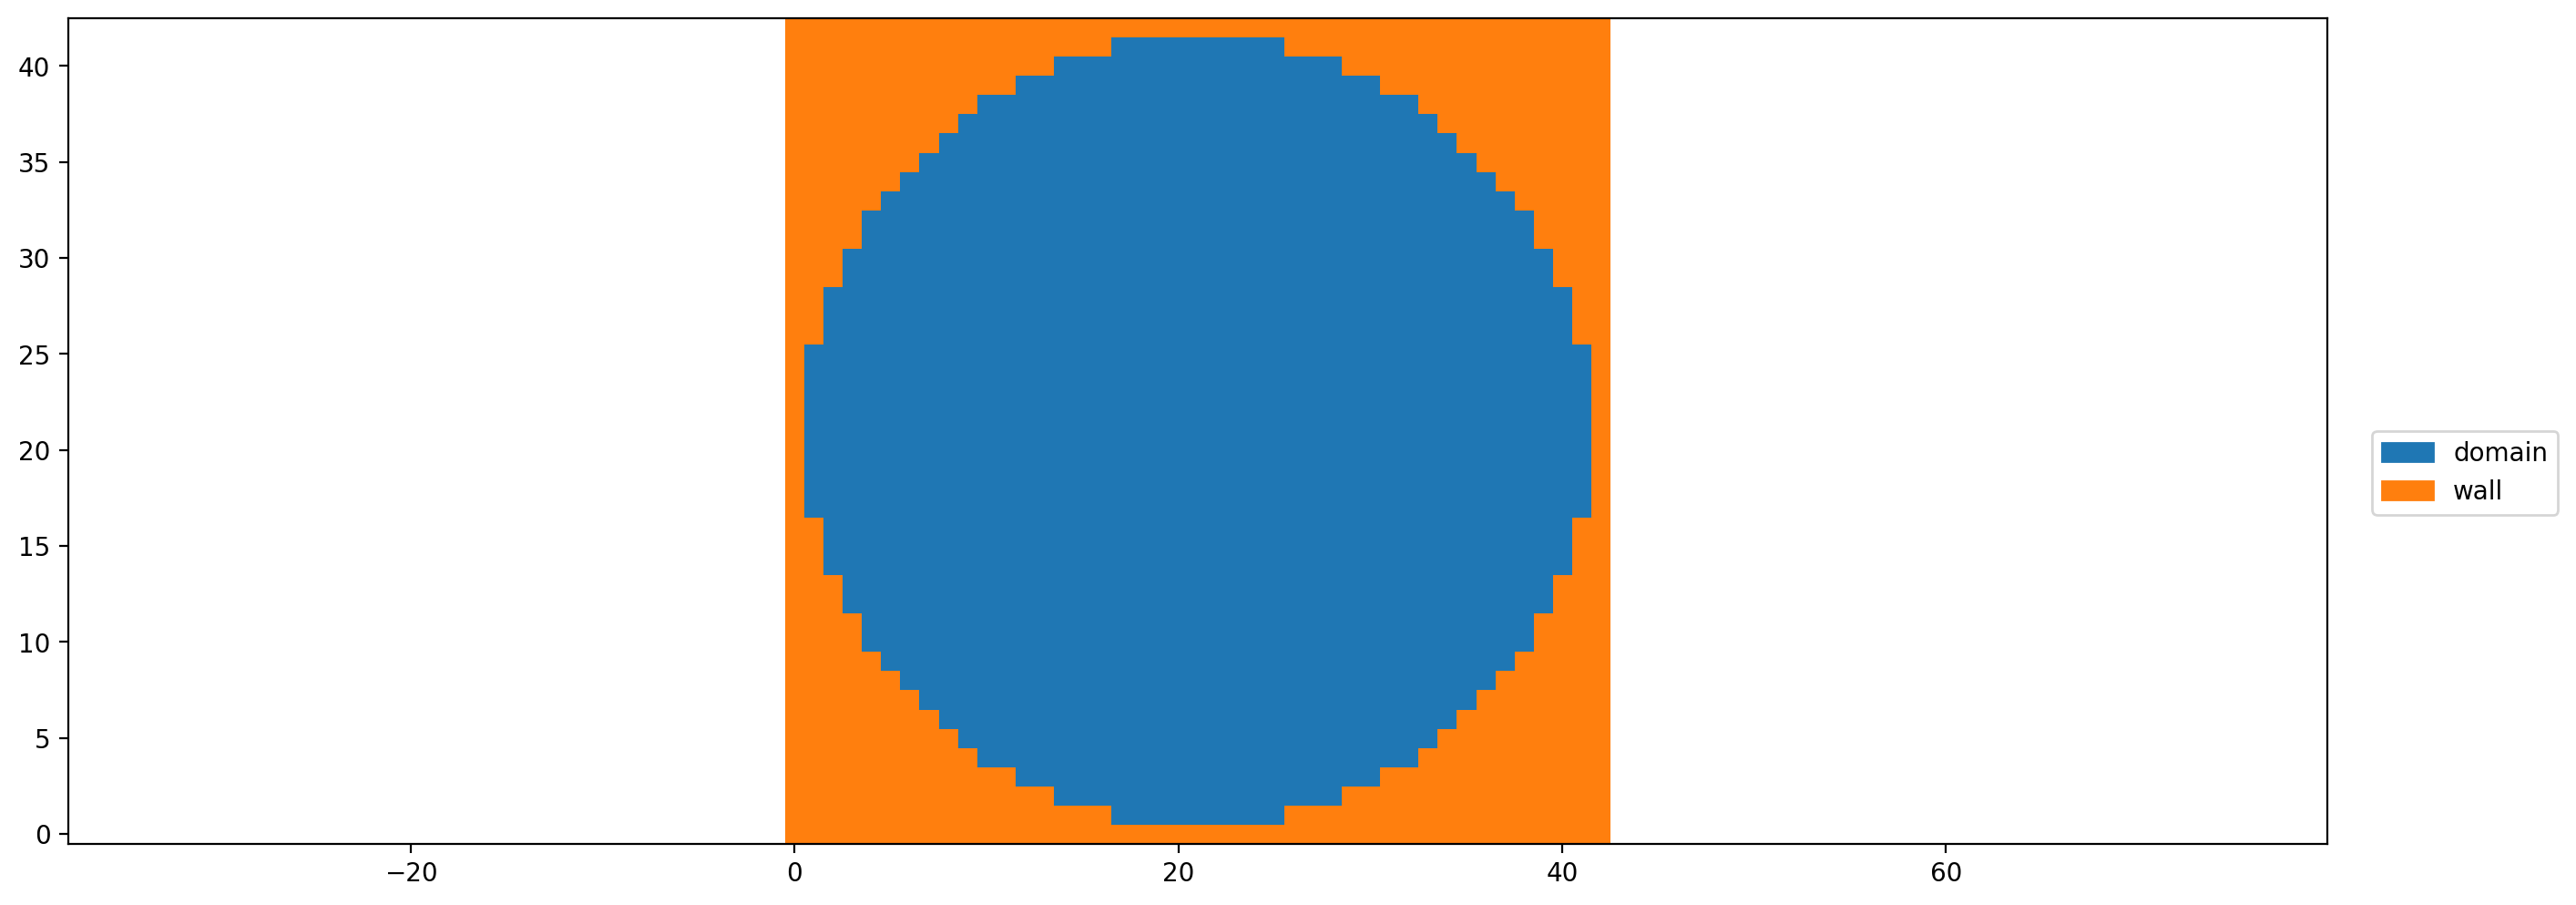

In [10]:
bh = LatticeBoltzmannBoundaryHandling(method, dh, src.name, name="bh")
peridocity = LBMPeriodicityHandling(stencil=stencil, data_handling=dh, pdf_field_name=src.name)

wall = NoSlip("wall")
bh.set_boundary(wall, mask_callback=pipe_geometry_callback)

plt.figure(dpi=200)
plt.boundary_handling(bh, make_slice[0.5, :, :])

In [11]:
def timeloop(timeSteps):
    for i in range(timeSteps):
        bh()
        peridocity()
        dh.run_kernel(kernel)
        dh.swap("src", "dst")

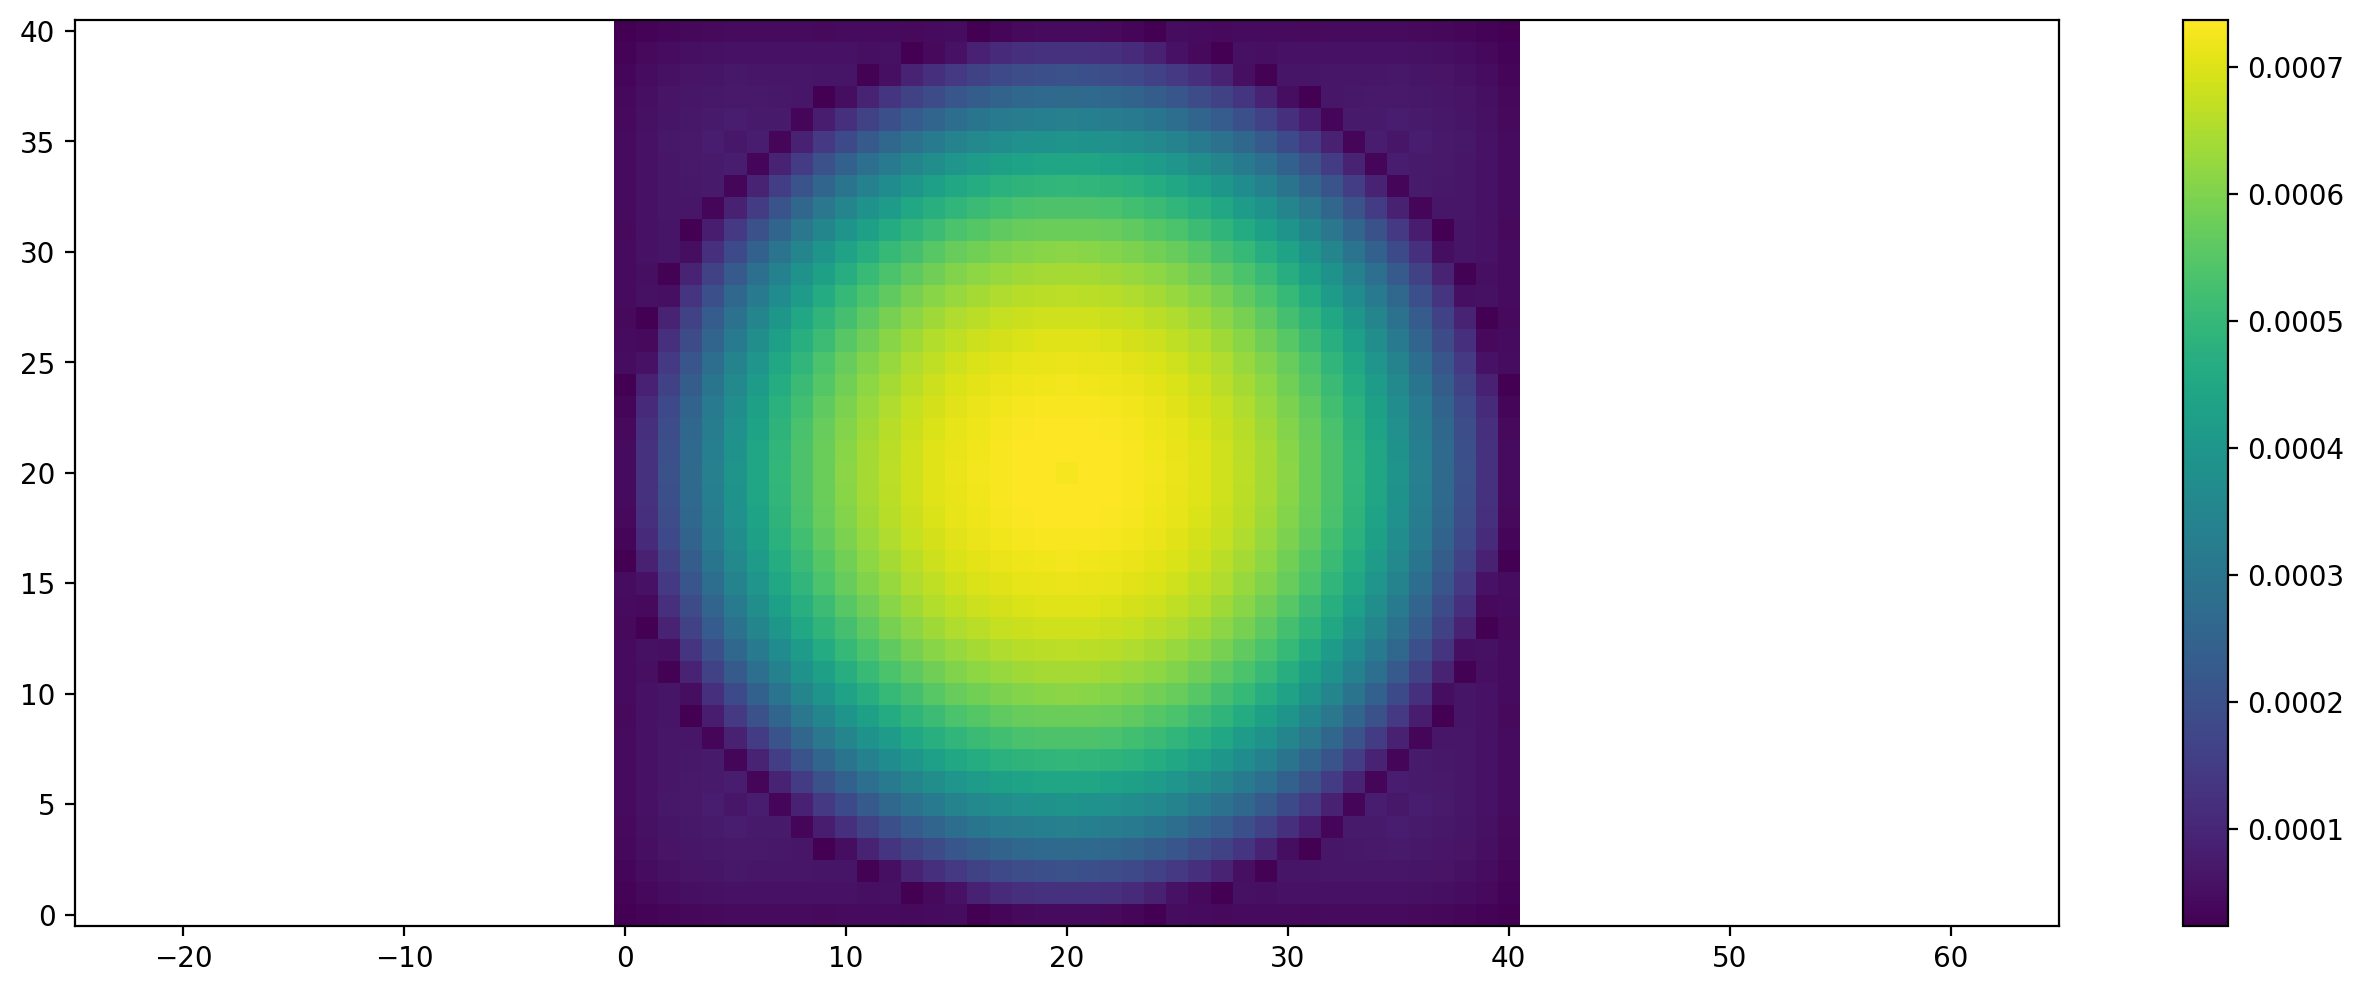

In [12]:
timeloop(2000)

plt.figure(dpi=200)
plt.scalar_field(dh.gather_array('velField')[domain_size[0] // 2, :, :, 0]);
plt.colorbar()

In [13]:
def poiseuille_profil(r, nu, a, dpdx, dim):
    dim_scale = 2 if dim == 2 else 1
    return -dim_scale/(4 * nu) * (a**2 - r**2) * dpdx

def poiseuille_profil_nN(r, rc, nu, a, dpdx, dim):
    dim_scale = 2 if dim == 2 else 1
    if abs(r) >= rc:
        p = a**2-r**2-8/3*rc**(1/2)*(a**(3/2)-abs(r)**(3/2))+2*rc*(a-abs(r))
    else:
        p = a**2-8/3*rc**(1/2)*a**(3/2)+2*rc*a-1/3*rc**2
    return -dim_scale/(4*nu)*dpdx*p


dpdx = -driving_force / L
if stencil.D == 2:
    r_c = abs(1/ math.sqrt(2)*sigma_y/dpdx)
elif stencil.D == 3:
    r_c = abs(1/ math.sqrt(2)*2*sigma_y/dpdx)

analytical_solution    = [poiseuille_profil(r, nu, W/2, dpdx, stencil.D) for r in range(math.ceil(-W/2), math.floor(W/2)+1)]
analytical_solution_nN = [poiseuille_profil_nN(r, r_c, nu, W/2, dpdx, stencil.D) for r in range(math.ceil(-W/2), math.floor(W/2)+1)]

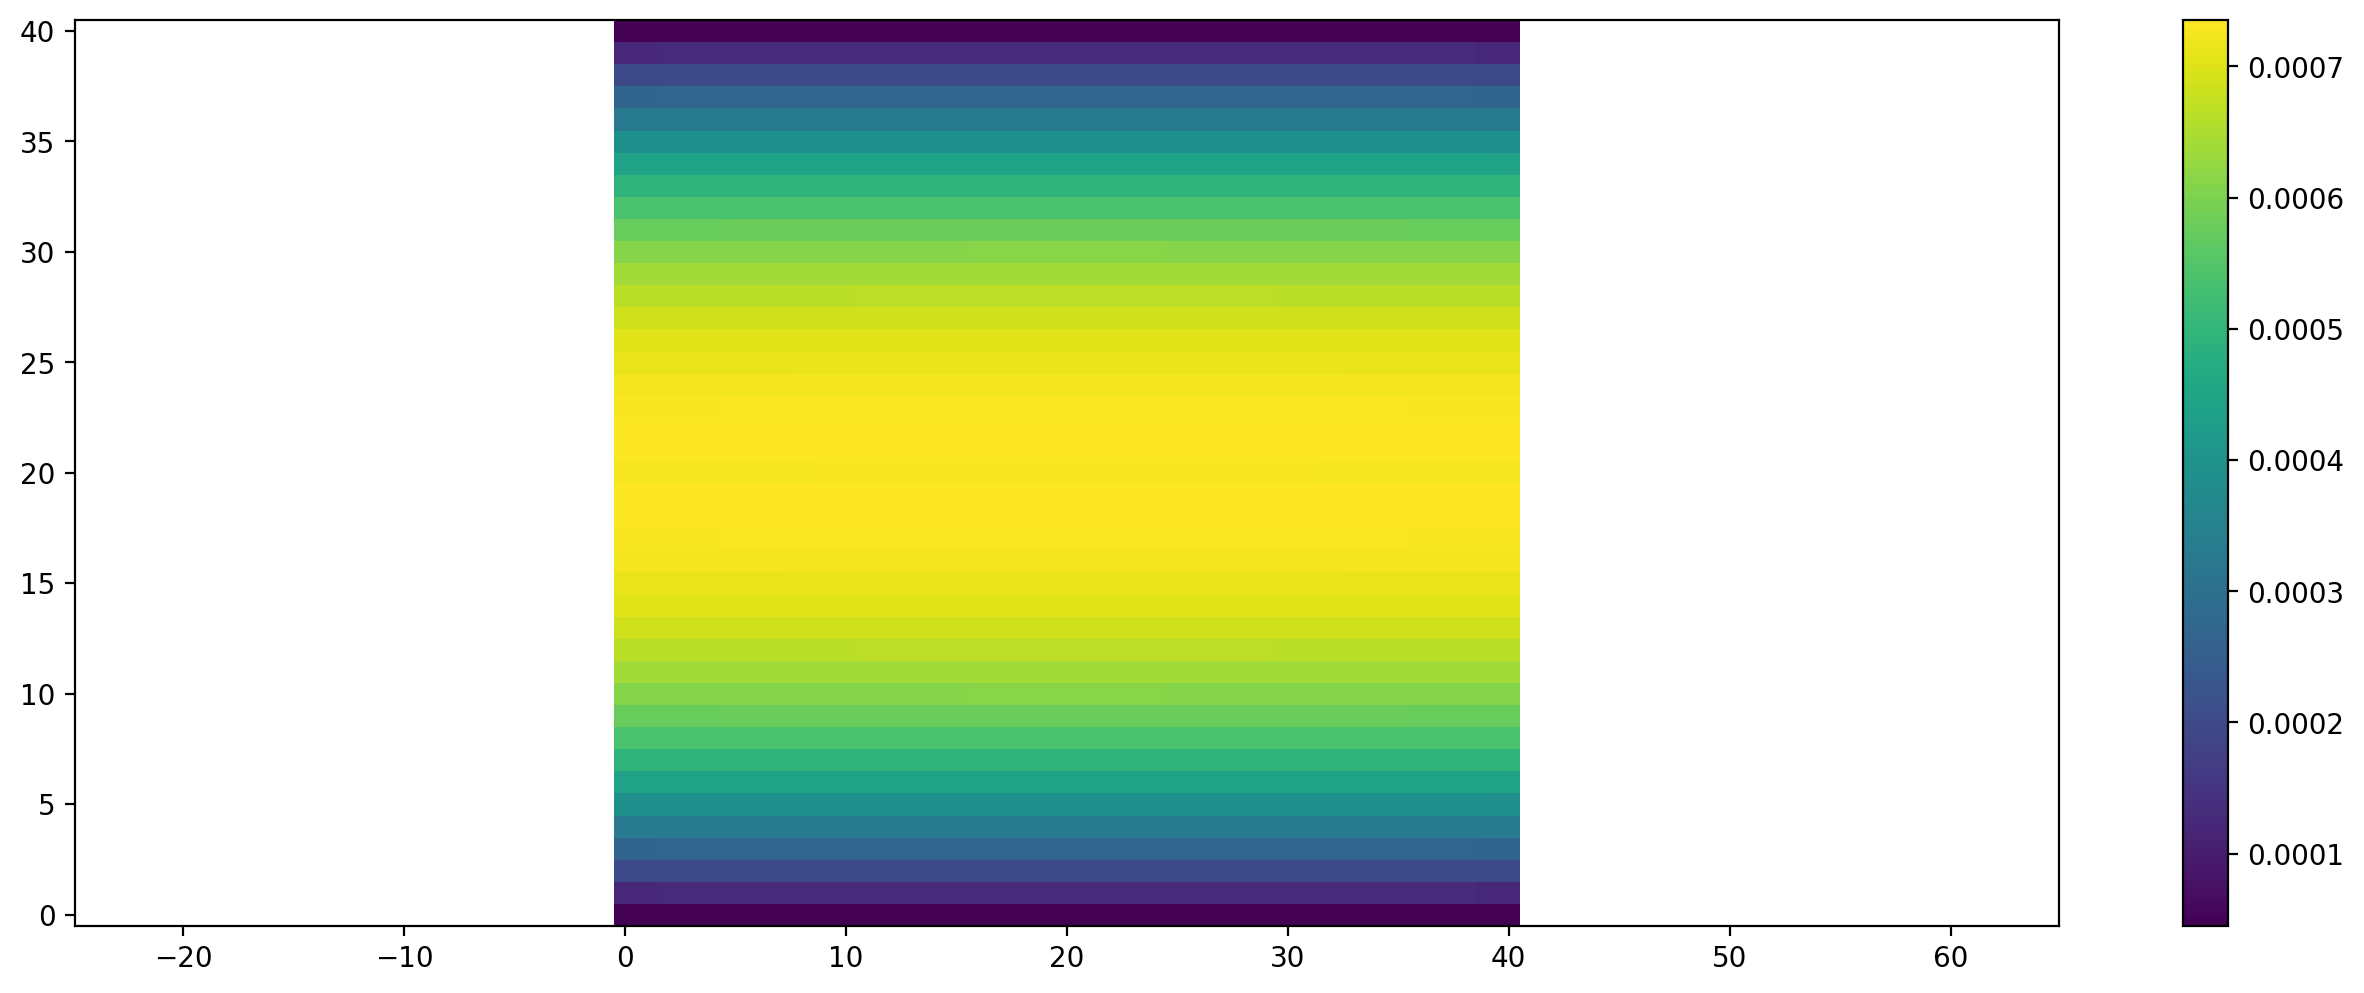

In [14]:
plt.figure(dpi=200)
plt.scalar_field(dh.gather_array('velField')[:, domain_size[1] // 2, :, 0]);
plt.colorbar()

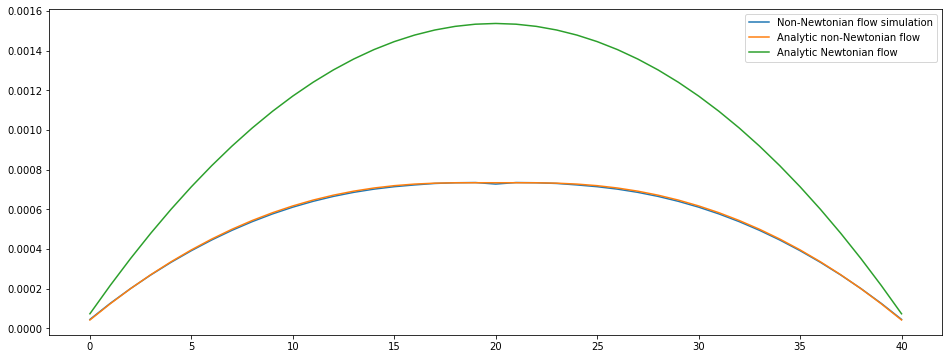

In [15]:
plt.plot(dh.gather_array(velField.name)[domain_size[0]//2, domain_size[1]//2, :, 0])
plt.plot(analytical_solution_nN)
plt.plot(analytical_solution)

plt.legend(["Non-Newtonian flow simulation", "Analytic non-Newtonian flow", "Analytic Newtonian flow"])

In [16]:
a = dh.gather_array(velField.name)[domain_size[0]//2, domain_size[1]//2, :, 0]
b = analytical_solution_nN

assert np.max((a - b) / b) < 0.07